In [ ]:
!pip install transformers

In [ ]:
#lib import
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as functional
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification, BertConfig
from torch.optim import AdamW # Import AdamW from torch.optim
import gc
from transformers import BertModel
from sklearn.metrics import roc_auc_score,f1_score
import time
import datetime

In [ ]:
#loading dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.manual_seed(0)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
if use_cuda:
    torch.cuda.manual_seed(0)

print("Using GPU: {}".format(use_cuda))

Using GPU: True


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/fake_news/constraint_train.csv')
val = pd.read_csv('/content/drive/MyDrive/fake_news/constraint_val.csv')
train["label"] = train["label"].map({"real": 1, "fake": 0})
val["label"] = val["label"].map({"real": 1, "fake": 0})

In [ ]:
train

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,1
1,2,States reported 1121 deaths a small rise from ...,1
2,3,Politically Correct Woman (Almost) Uses Pandem...,0
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,1
4,5,Populous states can generate large case counts...,1
...,...,...,...
6415,6416,A tiger tested positive for COVID-19 please st...,0
6416,6417,???Autopsies prove that COVID-19 is??� a blood...,0
6417,6418,_A post claims a COVID-19 vaccine has already ...,0
6418,6419,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,0


In [ ]:
val


,id,tweet,label
0,1,Chinese converting to Islam after realising th...,0
1,2,11 out of 13 people (from the Diamond Princess...,0
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",0
3,4,Mike Pence in RNC speech praises Donald Trump’...,0
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,1
...,...,...,...
2135,2136,Donald Trump wrongly claimed that New Zealand ...,0
2136,2137,Current understanding is #COVID19 spreads most...,1
2137,2138,Nothing screams “I am sat around doing fuck al...,0
2138,2139,Birx says COVID-19 outbreak not under control ...,0


In [ ]:
data = pd.concat([train,val], axis = 0, ignore_index=True).drop(["id"], axis =1)
data

,tweet,label
0,The CDC currently reports 99031 deaths. In gen...,1
1,States reported 1121 deaths a small rise from ...,1
2,Politically Correct Woman (Almost) Uses Pandem...,0
3,#IndiaFightsCorona: We have 1524 #COVID testin...,1
4,Populous states can generate large case counts...,1
...,...,...
8555,Donald Trump wrongly claimed that New Zealand ...,0
8556,Current understanding is #COVID19 spreads most...,1
8557,Nothing screams “I am sat around doing fuck al...,0
8558,Birx says COVID-19 outbreak not under control ...,0


**Tokenizing**


In [ ]:
from transformers import BertTokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
tweets = data.tweet.values
labels = data.label.values


In [ ]:
tweets

array(['The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.',
       'States reported 1121 deaths a small rise from last Tuesday. Southern states reported 640 of those deaths. https://t.co/YASGRTT4ux',
       'Politically Correct Woman (Almost) Uses Pandemic as Excuse Not to Reuse Plastic Bag https://t.co/thF8GuNFPe #coronavirus #nashville',
       ...,
       'Nothing screams “I am sat around doing fuck all during lockdown” quite like confident assumption that other people are sat around doing fuck all during lockdown https://t.co/Hs3rZAAl1h',
       'Birx says COVID-19 outbreak not under control because ‘people are on the move’ https://t.co/YFqi6f7Rvj',
       "Another 4422 new coronavirus cases have been confirmed in the UK - the highest daily number since 8 May. It's up from 4322 new cases reported on Friday and the overall total nationwide now 

In [ ]:
import re
from string import punctuation
def preprocess(data):
    #remove url and hashtag
    for i in range(data.shape[0]):
        text=data[i].lower()
        text1=''.join([word+" " for word in text.split()])
        data[i]=text1
    giant_url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|' \
        r'[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    mention_regex = r'@[\w\-]+'
    hashtag_regex = r'#[\w\-]+'
    space_pattern = r'\s+'

    for i in range(data.shape[0]):
        text_string = data[i]
        parsed_text = re.sub(hashtag_regex, '', text_string)
        parsed_text = re.sub(giant_url_regex, '', parsed_text)
        parsed_text = re.sub(mention_regex, '', parsed_text)
        #remove punctuation
        parsed_text = re.sub(r"[{}]+".format(punctuation), '', parsed_text)
        parsed_text = re.sub(space_pattern, ' ', parsed_text)
        data[i] = parsed_text
    return data
tweets = preprocess(tweets)
print(tweets)

['the cdc currently reports 99031 deaths in general the discrepancies in death counts between different sources are small and explicable the death toll stands at roughly 100000 people today '
 'states reported 1121 deaths a small rise from last tuesday southern states reported 640 of those deaths '
 'politically correct woman almost uses pandemic as excuse not to reuse plastic bag '
 ...
 'nothing screams “i am sat around doing fuck all during lockdown” quite like confident assumption that other people are sat around doing fuck all during lockdown '
 'birx says covid19 outbreak not under control because ‘people are on the move’ '
 'another 4422 new coronavirus cases have been confirmed in the uk the highest daily number since 8 may its up from 4322 new cases reported on friday and the overall total nationwide now stands at 385936 read the latest here ']


In [ ]:
# the original sentence.
print(' Original: ', tweets[0])

# the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(tweets[0]))

# the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[0])))

 Original:  the cdc currently reports 99031 deaths in general the discrepancies in death counts between different sources are small and explicable the death toll stands at roughly 100000 people today 
Tokenized:  ['the', 'cdc', 'currently', 'reports', '99', '##0', '##31', 'deaths', 'in', 'general', 'the', 'disc', '##re', '##pan', '##cies', 'in', 'death', 'counts', 'between', 'different', 'sources', 'are', 'small', 'and', 'ex', '##pl', '##ica', '##ble', 'the', 'death', 'toll', 'stands', 'at', 'roughly', '1000', '##00', 'people', 'today']
Token IDs:  [1996, 26629, 2747, 4311, 5585, 2692, 21486, 6677, 1999, 2236, 1996, 5860, 2890, 9739, 9243, 1999, 2331, 9294, 2090, 2367, 4216, 2024, 2235, 1998, 4654, 24759, 5555, 3468, 1996, 2331, 9565, 4832, 2012, 5560, 6694, 8889, 2111, 2651]


In [ ]:
max_len = 0
ind = [100,200,300,400,500,512]
for i in ind:
  count = 0
  for tweet in tweets:
      max_len = max(max_len, len(tweet))
      if len(tweet)>i:
        count+=1
  print("Count of sentence length over {} is: ".format(i), count)
print('Max sentence length: ', max_len)

Count of sentence length over 100 is:  5667
Count of sentence length over 200 is:  2327
Count of sentence length over 300 is:  59
Count of sentence length over 400 is:  20
Count of sentence length over 500 is:  13
Count of sentence length over 512 is:  10
Max sentence length:  8672


In [ ]:
input_ids = []
attention_masks = []
for tweet in tweets:
    encoded_dict = tokenizer.encode_plus(
                        tweet,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        padding='max_length',       # Pad to max_length
                        truncation=True,            # Truncate to max_length
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', tweets[0])
print('Token IDs:', input_ids[0])

Original:  the cdc currently reports 99031 deaths in general the discrepancies in death counts between different sources are small and explicable the death toll stands at roughly 100000 people today 
Token IDs: tensor([  101,  1996, 26629,  2747,  4311,  5585,  2692, 21486,  6677,  1999,
         2236,  1996,  5860,  2890,  9739,  9243,  1999,  2331,  9294,  2090,
         2367,  4216,  2024,  2235,  1998,  4654, 24759,  5555,  3468,  1996,
         2331,  9565,  4832,  2012,  5560,  6694,  8889,  2111,  2651,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
         

**Train and Test**

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size],generator=torch.Generator().manual_seed(42))

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,704 training samples
  856 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_dataloader = DataLoader(
            train_dataset,
            shuffle = True,
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            shuffle = False,
            batch_size = batch_size
        )

In [ ]:
def format_time(elapsed):
  elapse_rounded = int(round((elapsed)))
  return str(datetime.timedelta(seconds=elapse_rounded))

**Fine-tunning**

In [ ]:
from transformers import BertForSequenceClassification, BertConfig
from torch.optim import AdamW # Import AdamW from torch.optim
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8)
epochs = 4
criterion = nn.CrossEntropyLoss()

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()
best_accuracy = 0
for epoch_i in range(0, epochs):
    #Training
    print("")
    print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model.train()
    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()
        out = model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)
        loss = out[0]
        logits = out[1]

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        pred = torch.argmax(logits, dim = 1)
        total_train_accuracy +=  torch.sum(pred == labels).item()

    avg_train_accuracy = total_train_accuracy / len(train_dataloader.dataset)
    avg_train_loss = total_train_loss / len(train_dataloader.dataset)
    print("  Accuracy: {}".format(avg_train_accuracy))
    print("  Training loss: {}".format(avg_train_loss))


    # Validation
    print("")
    print("Validation...")
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []

    for batch in validation_dataloader:
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            out = model(input_ids, token_type_ids=None, attention_mask=input_mask,labels=labels)
            loss = out[0]
            logits = out[1]

        total_eval_loss += loss.item()
        pred = torch.argmax(logits, dim = 1)
        total_eval_accuracy += torch.sum(pred == labels).item()
        y_true.append(labels.flatten())
        y_pred.append(pred.flatten())

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader.dataset)
    print("  Accuracy: {}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader.dataset)
    print("  Validation loss: {}".format(avg_val_loss))
    training_time = format_time(time.time() - t0)
    print()

    y_true = torch.cat(y_true).tolist()
    y_pred = torch.cat(y_pred).tolist()
    print("This epoch took: {:}".format(training_time))
    print('roc_auc score: ', roc_auc_score(y_true,y_pred))
    print('F1 score:',f1_score(y_true, y_pred))
    print()

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Train Accur.': avg_train_accuracy,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
        }
    )
    print()

    if avg_val_accuracy > best_accuracy:
        best_accuracy = avg_val_accuracy
        best_model = model

print()
print("="*10)
print("Summary")
print("Total time {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


Epoch 1 / 4
Training...
  Accuracy: 0.9039460020768432
  Training loss: 0.016830906137869514

Validation...
  Accuracy: 0.9392523364485982
  Validation loss: 0.009888079604917319

This epoch took: 0:11:31
roc_auc score:  0.9396127699097049
F1 score: 0.9433551198257081



Epoch 2 / 4
Training...
  Accuracy: 0.965472481827622
  Training loss: 0.008135786755534537

Validation...
  Accuracy: 0.9462616822429907
  Validation loss: 0.014990743295622501

This epoch took: 0:11:35
roc_auc score:  0.9457075495029099
F1 score: 0.9504310344827587



Epoch 3 / 4
Training...
  Accuracy: 0.9863707165109035
  Training loss: 0.003487810122639274

Validation...
  Accuracy: 0.9521028037383178
  Validation loss: 0.016247515740930037

This epoch took: 0:11:35
roc_auc score:  0.95245357470639
F1 score: 0.955386289445049



Epoch 4 / 4
Training...
  Accuracy: 0.9953271028037384
  Training loss: 0.001412388472878849

Validation...
  Accuracy: 0.9532710280373832
  Validation loss: 0.01812216786414882

This epo

In [ ]:
MODEL = "/content/drive/MyDrive/fake_news/'bert_model.pt'"
torch.save(model, MODEL)

In [ ]:
PATH1 = "/content/drive/MyDrive/fake_news/'bert_model.pt'"
the_best_model = torch.load(PATH1, map_location='cpu', weights_only=False)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       393
           1       0.97      0.94      0.96       463

    accuracy                           0.95       856
   macro avg       0.95      0.95      0.95       856
weighted avg       0.95      0.95      0.95       856


Confusion Matrix:


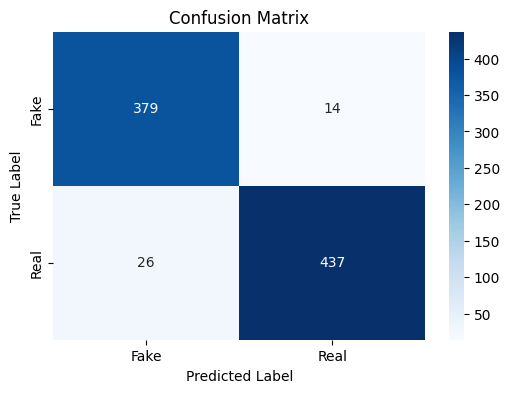

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# y_true and y_pred were collected during the validation phase in the training loop
# If you have rerun the notebook and these variables are not available,
# you would need to run the validation loop again to get them.

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

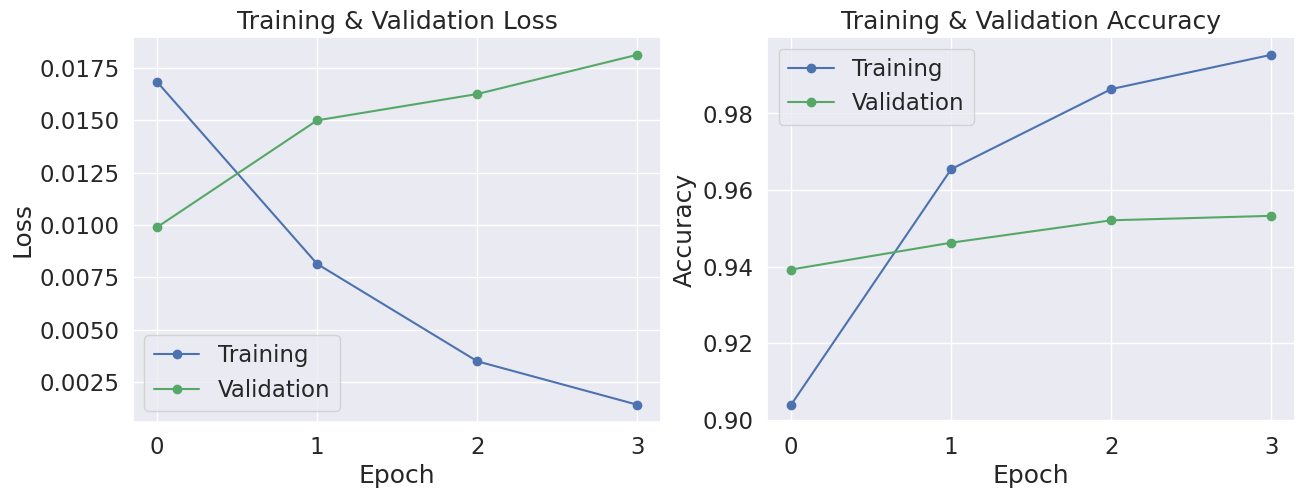

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Create a DataFrame from the training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use seaborn for enhanced aesthetics
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (15,8)

# Plot the learning curve.
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(df_stats.index)

plt.subplot(1, 2, 2)
plt.plot(df_stats['Train Accur.'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Accur.'], 'g-o', label="Validation")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(df_stats.index)


plt.show()

In [ ]:
from collections import Counter
import itertools

# Filter the data to include only fake news
fake_news_data = data[data['label'] == 0]

# Get all the words from the fake news tweets
fake_news_words = fake_news_data['tweet'].str.split().tolist()
fake_news_words = list(itertools.chain.from_iterable(fake_news_words))

# Count the frequency of each word
fake_news_word_counts = Counter(fake_news_words)

In [ ]:
# Display the top 20 most frequent words in fake news
print("Top 20 most frequent words in fake news:")
for word, count in fake_news_word_counts.most_common(20):
    print(f"{word}: {count}")

Top 20 most frequent words in fake news:
the: 3818
a: 2205
to: 2144
of: 2021
in: 1932
coronavirus: 1366
and: 1354
covid19: 1312
is: 1070
for: 955
that: 906
from: 644
on: 638
has: 569
with: 531
are: 489
it: 470
by: 439
not: 415
was: 389


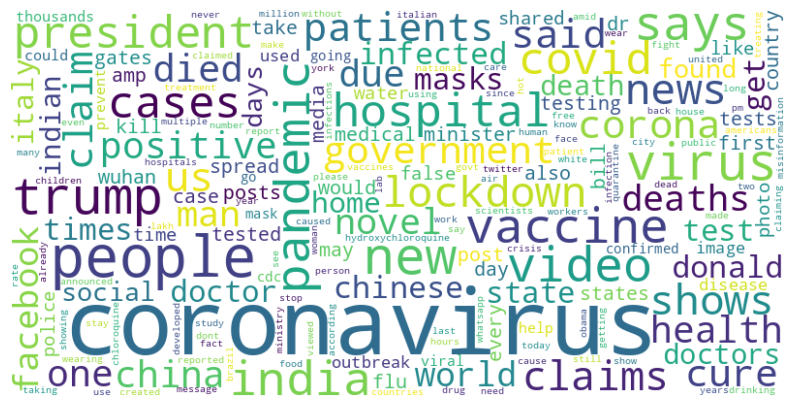

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate a word cloud from the fake news word counts
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fake_news_word_counts)

# Display the generated word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

BERT + BiLSTM

In [ ]:
PATH1 = "/content/drive/MyDrive/fake_news/'bert_model.pt'"
the_best_model = torch.load(PATH1, map_location='cpu', weights_only=False)

In [ ]:
class BertCNNClassifier(nn.Module):
    def __init__(self, tuned_model, embed_num = 512, embed_dim = 768, dropout=0.1, kernel_num=3, kernel_sizes=[1,2], num_labels=2):
        super().__init__()
        self.num_labels = num_labels
        self.embed_num = embed_num
        self.embed_dim = embed_dim
        self.dropout = dropout
        self.kernel_num = kernel_num
        self.kernel_sizes = kernel_sizes
        self.softmax = nn.functional.softmax

        self.bert = tuned_model.bert
        self.convs = nn.ModuleList([nn.Conv2d(1, self.kernel_num, (k, self.embed_dim)) for k in self.kernel_sizes])
        self.dropout = nn.Dropout(self.dropout)
        self.classifier = nn.Linear(len(self.kernel_sizes)*self.kernel_num, self.num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids = None):
        output = self.bert(input_ids = input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids) #16,512,768
        output = output[0].unsqueeze(1) #16,1,512,768
        output = [nn.functional.relu(conv(output)).squeeze(3) for conv in self.convs] #16,3,508,1 => #16,3,508
        output = [nn.functional.max_pool1d(i, i.size(2)).squeeze(2) for i in output] #=> 16,3
        output = torch.cat(output, 1)
        output = self.dropout(output)
        logits = self.classifier(output)
        return self.softmax(logits, 1)


In [ ]:
# Initializing model
model2 = BertCNNClassifier(model).cuda()
# set parameters
epochs = 4
learning_rate = 5e-5
optimizer = AdamW(model2.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
class BertLstmClassifier(nn.Module):
    def __init__(self, model_tune):
        super().__init__()
        self.bert = model_tune.bert
        self.lstm = nn.LSTM(input_size = 768,
                            hidden_size = 768,
                            num_layers = 1,
                            batch_first = True,
                            bidirectional = True)
        self.classifier = nn.Linear(768 * 2, 2)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        bert_output = self.bert(input_ids = input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids)
        out, _ = self.lstm(bert_output[0])
        logits = self.classifier(out[:, 1, :])
        return self.softmax(logits)

In [ ]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()
best_accuracy = 0
for epoch_i in range(0, epochs):
    #Training
    print("")
    print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model2.train()
    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model2.zero_grad()
        out = model2(input_ids = input_ids, attention_mask = input_mask, token_type_ids = None)
        loss = criterion(out, labels)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

        pred = torch.argmax(out, dim = 1)
        total_train_accuracy +=  torch.sum(pred == labels).item()

    avg_train_accuracy = total_train_accuracy / len(train_dataloader.dataset)
    avg_train_loss = total_train_loss / len(train_dataloader.dataset)
    print("  Accuracy: {}".format(avg_train_accuracy))
    print("  Training loss: {}".format(avg_train_loss))

    # Validation
    print("")
    print("Validation...")
    model2.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []

    for batch in validation_dataloader:
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            out = model2(input_ids = input_ids, attention_mask = input_mask, token_type_ids = None)
        loss = criterion(out, labels)
        total_eval_loss += loss.item()
        pred = torch.argmax(out, dim = 1)
        total_eval_accuracy += torch.sum(pred == labels).item()
        y_true.append(labels.flatten())
        y_pred.append(pred.flatten())

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader.dataset)
    print("  Accuracy: {}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader.dataset)
    print("  Validation loss: {}".format(avg_val_loss))
    training_time = format_time(time.time() - t0)
    print("  This epoch took: {:}".format(training_time))
    print()
    y_true = torch.cat(y_true).tolist()
    y_pred = torch.cat(y_pred).tolist()
    print('  roc_auc score: ', roc_auc_score(y_true,y_pred))
    print('  F1 score:',f1_score(y_true, y_pred))


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Train Accur.': avg_train_accuracy,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
        }
    )

    if avg_val_accuracy > best_accuracy:
        best_accuracy = avg_val_accuracy
        best_model = model2

print("===")
print("Summary")
print("Total time {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
print('best acc:',best_accuracy)


Epoch 1 / 4
Training...
  Accuracy: 0.8856438213914849
  Training loss: 0.027031882978426458

Validation...
  Accuracy: 0.9287383177570093
  Validation loss: 0.02417475907741306
  This epoch took: 0:11:57

  roc_auc score:  0.9316247066646881
  F1 score: 0.9315375982042648

Epoch 2 / 4
Training...
  Accuracy: 0.9288681204569055
  Training loss: 0.02413886816067735

Validation...
  Accuracy: 0.9228971962616822
  Validation loss: 0.02451400573704844
  This epoch took: 0:11:58

  roc_auc score:  0.9248786814612083
  F1 score: 0.9266666666666666

Epoch 3 / 4
Training...
  Accuracy: 0.9430166147455867
  Training loss: 0.023268103081179804

Validation...
  Accuracy: 0.9182242990654206
  Validation loss: 0.02470780891653533
  This epoch took: 0:11:58

  roc_auc score:  0.9155579004061355
  F1 score: 0.9261603375527426

Epoch 4 / 4
Training...
  Accuracy: 0.9454828660436138
  Training loss: 0.02306678196800213

Validation...
  Accuracy: 0.9310747663551402
  Validation loss: 0.0240225700365605

In [ ]:
PATH2= "/content/drive/MyDrive/fake_news/'cnn1.pt'"
torch.save(model2, PATH2)

With freeze param

In [ ]:
class BertCNNClassifier(nn.Module):
    def __init__(self, tuned_model, embed_num = 512, embed_dim = 768, dropout=0.1, kernel_num=3, kernel_sizes=[1,2], num_labels=2):
        super().__init__()
        self.num_labels = num_labels
        self.embed_num = embed_num
        self.embed_dim = embed_dim
        self.dropout = dropout
        self.kernel_num = kernel_num
        self.kernel_sizes = kernel_sizes
        self.softmax = nn.functional.softmax

        self.bert = tuned_model.bert
        self.convs = nn.ModuleList([nn.Conv2d(1, self.kernel_num, (k, self.embed_dim)) for k in self.kernel_sizes])
        self.dropout = nn.Dropout(self.dropout)
        self.classifier = nn.Linear(len(self.kernel_sizes)*self.kernel_num, self.num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids = None):
        output = self.bert(input_ids = input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids) #16,512,768
        output = output[0].unsqueeze(1) #16,1,512,768
        output = [nn.functional.relu(conv(output)).squeeze(3) for conv in self.convs] #16,3,508,1 => #16,3,508
        output = [nn.functional.max_pool1d(i, i.size(2)).squeeze(2) for i in output] #=> 16,3
        output = torch.cat(output, 1)
        output = self.dropout(output)
        logits = self.classifier(output)
        return self.softmax(logits, 1)

In [ ]:
# Initializing model
model3 = BertCNNClassifier(the_best_model).cuda()
for param in model3.bert.parameters():
    param.requires_grad = False
# set parameters
epochs = 4
learning_rate = 5e-5
optimizer = AdamW(model3.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()
best_accuracy = 0
for epoch_i in range(0, epochs):
    #Training
    print("")
    print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model3.train()
    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model3.zero_grad()
        out = model3(input_ids = input_ids, attention_mask = input_mask, token_type_ids = None)
        loss = criterion(out, labels)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model3.parameters(), 1.0)
        optimizer.step()

        pred = torch.argmax(out, dim = 1)
        total_train_accuracy +=  torch.sum(pred == labels).item()

    avg_train_accuracy = total_train_accuracy / len(train_dataloader.dataset)
    avg_train_loss = total_train_loss / len(train_dataloader.dataset)
    print("  Accuracy: {}".format(avg_train_accuracy))
    print("  Training loss: {}".format(avg_train_loss))

    # Validation
    print("")
    print("Validation...")
    model3.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []

    for batch in validation_dataloader:
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            out = model3(input_ids = input_ids, attention_mask = input_mask, token_type_ids = None)
        loss = criterion(out, labels)
        total_eval_loss += loss.item()
        pred = torch.argmax(out, dim = 1)
        total_eval_accuracy += torch.sum(pred == labels).item()
        y_true.append(labels.flatten())
        y_pred.append(pred.flatten())

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader.dataset)
    print("  Accuracy: {}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader.dataset)
    print("  Validation loss: {}".format(avg_val_loss))
    training_time = format_time(time.time() - t0)
    print("  This epoch took: {:}".format(training_time))
    print()
    y_true = torch.cat(y_true).tolist()
    y_pred = torch.cat(y_pred).tolist()
    print('  roc_auc score: ', roc_auc_score(y_true,y_pred))
    print('  F1 score:',f1_score(y_true, y_pred))


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Train Accur.': avg_train_accuracy,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
        }
    )

    if avg_val_accuracy > best_accuracy:
        best_accuracy = avg_val_accuracy
        best_model = model3

print("===")
print("Summary")
print("Total time {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
print('best acc:',best_accuracy)


Epoch 1 / 4
Training...
  Accuracy: 0.9788421599169262
  Training loss: 0.023680032881775625

Validation...
  Accuracy: 0.955607476635514
  Validation loss: 0.02279386979257949
  This epoch took: 0:04:19

  roc_auc score:  0.9556933155271242
  F1 score: 0.9587852494577006

Epoch 2 / 4
Training...
  Accuracy: 0.995067497403946
  Training loss: 0.020291311923619496

Validation...
  Accuracy: 0.955607476635514
  Validation loss: 0.022566835491735243
  This epoch took: 0:04:19

  roc_auc score:  0.9556933155271242
  F1 score: 0.9587852494577006

Epoch 3 / 4
Training...
  Accuracy: 0.9949376947040498
  Training loss: 0.020010315454328048

Validation...
  Accuracy: 0.955607476635514
  Validation loss: 0.022535562898232556
  This epoch took: 0:04:19

  roc_auc score:  0.9556933155271242
  F1 score: 0.9587852494577006

Epoch 4 / 4
Training...
  Accuracy: 0.9936396677050883
  Training loss: 0.019939365633303997

Validation...
  Accuracy: 0.955607476635514
  Validation loss: 0.02253231674293491

In [ ]:
PATH3= "/content/drive/MyDrive/fake_news/'cnn2.pt'"
torch.save(model3, PATH3)

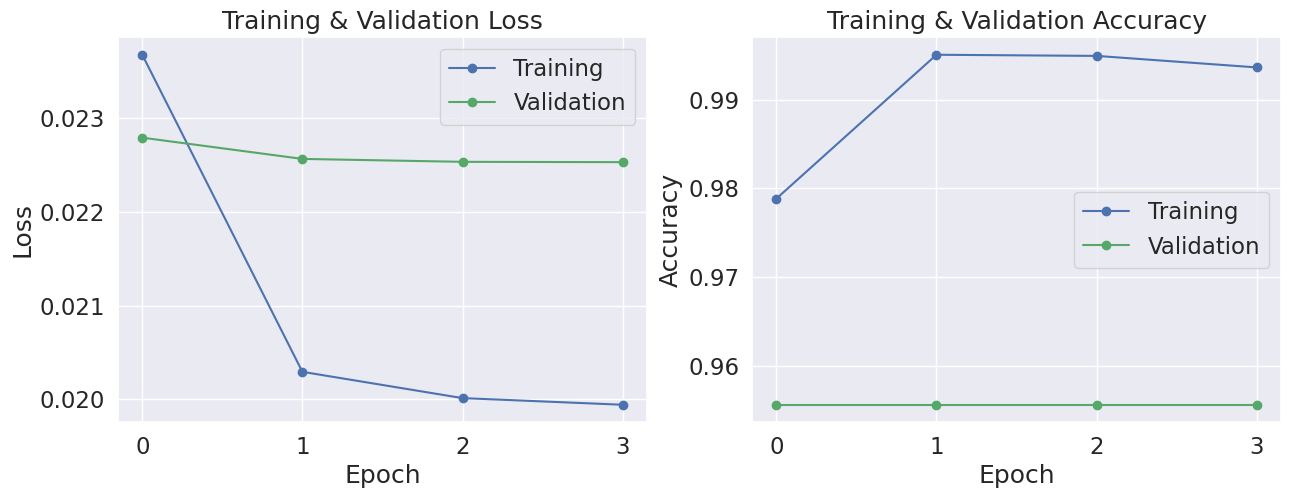

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Create a DataFrame from the training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use seaborn for enhanced aesthetics
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (15,8)

# Plot the learning curve.
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(df_stats.index)

plt.subplot(1, 2, 2)
plt.plot(df_stats['Train Accur.'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Accur.'], 'g-o', label="Validation")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(df_stats.index)


plt.show()

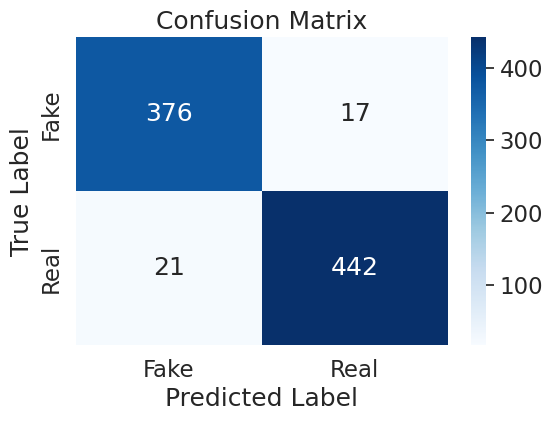

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_true and y_pred are available from your model evaluation
# Replace with your actual true and predicted labels

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Bert+BiLSTM**

Without free param

In [ ]:
class BertLstmClassifier(nn.Module):
    def __init__(self, model_tune):
        super().__init__()
        self.bert = model_tune.bert
        self.lstm = nn.LSTM(input_size = 768,
                            hidden_size = 768,
                            num_layers = 1,
                            batch_first = True,
                            bidirectional = True)
        self.classifier = nn.Linear(768 * 2, 2)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        bert_output = self.bert(input_ids = input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids)
        out, _ = self.lstm(bert_output[0])
        logits = self.classifier(out[:, 1, :])
        return self.softmax(logits)

In [ ]:
# Initializing model
model4 = BertLstmClassifier(the_best_model).cuda()
# set parameters
epochs = 4
learning_rate = 5e-5
optimizer = AdamW(model4.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()
best_accuracy = 0
for epoch_i in range(0, epochs):
    #Training
    print("")
    print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model4.train()
    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model4.zero_grad()
        out = model4(input_ids = input_ids, attention_mask = input_mask, token_type_ids = None)
        loss = criterion(out, labels)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model4.parameters(), 1.0)
        optimizer.step()

        pred = torch.argmax(out, dim = 1)
        total_train_accuracy +=  torch.sum(pred == labels).item()

    avg_train_accuracy = total_train_accuracy / len(train_dataloader.dataset)
    avg_train_loss = total_train_loss / len(train_dataloader.dataset)
    print("  Accuracy: {}".format(avg_train_accuracy))
    print("  Training loss: {}".format(avg_train_loss))

    # Validation
    print("")
    print("Validation...")
    model4.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []

    for batch in validation_dataloader:
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            out = model4(input_ids = input_ids, attention_mask = input_mask, token_type_ids = None)
        loss = criterion(out, labels)
        total_eval_loss += loss.item()
        pred = torch.argmax(out, dim = 1)
        total_eval_accuracy += torch.sum(pred == labels).item()
        y_true.append(labels.flatten())
        y_pred.append(pred.flatten())

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader.dataset)
    print("  Accuracy: {}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader.dataset)
    print("  Validation loss: {}".format(avg_val_loss))
    training_time = format_time(time.time() - t0)
    print("  This epoch took: {:}".format(training_time))
    print()
    y_true = torch.cat(y_true).tolist()
    y_pred = torch.cat(y_pred).tolist()
    print('  roc_auc score: ', roc_auc_score(y_true,y_pred))
    print('  F1 score:',f1_score(y_true, y_pred))


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Train Accur.': avg_train_accuracy,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
        }
    )

    if avg_val_accuracy > best_accuracy:
        best_accuracy = avg_val_accuracy
        best_model = model4

print("===")
print("Summary")
print("Total time {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
print('best acc:',best_accuracy)


Epoch 1 / 4
Training...
  Accuracy: 0.9836448598130841
  Training loss: 0.020806756563028196

Validation...
  Accuracy: 0.9264018691588785
  Validation loss: 0.024447359875819395
  This epoch took: 0:14:34

  roc_auc score:  0.9227325936062519
  F1 score: 0.9343065693430657

Epoch 2 / 4
Training...
  Accuracy: 0.9636552440290758
  Training loss: 0.02187263969088269

Validation...
  Accuracy: 0.927570093457944
  Validation loss: 0.024249721875536107
  This epoch took: 0:14:33

  roc_auc score:  0.9247742623338224
  F1 score: 0.9347368421052632

Epoch 3 / 4
Training...
  Accuracy: 0.967159916926272
  Training loss: 0.021635335271448855

Validation...
  Accuracy: 0.9287383177570093
  Validation loss: 0.02425486246280581
  This epoch took: 0:14:33

  roc_auc score:  0.9289317923268429
  F1 score: 0.9336235038084875

Epoch 4 / 4
Training...
  Accuracy: 0.9750778816199377
  Training loss: 0.021151903598943603

Validation...
  Accuracy: 0.9357476635514018
  Validation loss: 0.023803839651502

In [ ]:
PATH4= "/content/drive/MyDrive/fake_news/'bilstm.pt'"
torch.save(model4, PATH4)

PicklingError: Can't pickle <class '__main__.BertLstmClassifier'>: it's not the same object as __main__.BertLstmClassifier

In [ ]:
#With freeze param
class BertLstmClassifier(nn.Module):
    def __init__(self, model_tune):
        super().__init__()
        self.bert = model_tune.bert
        self.lstm = nn.LSTM(input_size = 768,
                            hidden_size = 768,
                            num_layers = 2,
                            batch_first = True,
                            bidirectional = True)
        self.classifier = nn.Linear(768 * 2, 2)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        bert_output = self.bert(input_ids = input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids)
        out, _ = self.lstm(bert_output[0])
        logits = self.classifier(out[:, 1, :])
        return self.softmax(logits)

In [ ]:
model5 = BertLstmClassifier(the_best_model).cuda()
for param in model5.bert.parameters():
    param.requires_grad = False
# set parameters
epochs = 10
learning_rate = 5e-5
optimizer = AdamW(model5.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()
best_accuracy = 0
for epoch_i in range(0, epochs):
    #Training
    print("")
    print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model5.train()
    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model5.zero_grad()
        out = model5(input_ids = input_ids, attention_mask = input_mask, token_type_ids = None)
        loss = criterion(out, labels)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model5.parameters(), 1.0)
        optimizer.step()

        pred = torch.argmax(out, dim = 1)
        total_train_accuracy +=  torch.sum(pred == labels).item()

    avg_train_accuracy = total_train_accuracy / len(train_dataloader.dataset)
    avg_train_loss = total_train_loss / len(train_dataloader.dataset)
    print("  Accuracy: {}".format(avg_train_accuracy))
    print("  Training loss: {}".format(avg_train_loss))

    # Validation
    print("")
    print("Validation...")
    model5.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []

    for batch in validation_dataloader:
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            out = model5(input_ids = input_ids, attention_mask = input_mask, token_type_ids = None)
        loss = criterion(out, labels)
        total_eval_loss += loss.item()
        pred = torch.argmax(out, dim = 1)
        total_eval_accuracy += torch.sum(pred == labels).item()
        y_true.append(labels.flatten())
        y_pred.append(pred.flatten())

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader.dataset)
    print("  Accuracy: {}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader.dataset)
    print("  Validation loss: {}".format(avg_val_loss))
    training_time = format_time(time.time() - t0)
    print("  This epoch took: {:}".format(training_time))
    print()
    y_true = torch.cat(y_true).tolist()
    y_pred = torch.cat(y_pred).tolist()
    print('  roc_auc score: ', roc_auc_score(y_true,y_pred))
    print('  F1 score:',f1_score(y_true, y_pred))


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Train Accur.': avg_train_accuracy,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
        }
    )

    if avg_val_accuracy > best_accuracy:
        best_accuracy = avg_val_accuracy
        best_model = model5

print("===")
print("Summary")
print("Total time {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
print('best acc:',best_accuracy)


Epoch 1 / 10
Training...
  Accuracy: 0.9980529595015576
  Training loss: 0.019964669936511623

Validation...
  Accuracy: 0.9509345794392523
  Validation loss: 0.022782703147870356
  This epoch took: 0:08:56

  roc_auc score:  0.9500272039305558
  F1 score: 0.9549356223175965

Epoch 2 / 10
Training...
  Accuracy: 0.9990913811007269
  Training loss: 0.019654996221186834

Validation...
  Accuracy: 0.9509345794392523
  Validation loss: 0.022783607871175927
  This epoch took: 0:08:55

  roc_auc score:  0.9498348529064241
  F1 score: 0.9550321199143469

Epoch 3 / 10
Training...
  Accuracy: 0.9990913811007269
  Training loss: 0.01965657199190413

Validation...
  Accuracy: 0.9509345794392523
  Validation loss: 0.022822105125567625
  This epoch took: 0:08:55

  roc_auc score:  0.9502195549546875
  F1 score: 0.9548387096774194

Epoch 4 / 10
Training...
  Accuracy: 0.9979231568016614
  Training loss: 0.019727469318442874

Validation...
  Accuracy: 0.9521028037383178
  Validation loss: 0.02275553

In [ ]:
PATH5= "/content/drive/MyDrive/fake_news/'bilstm.pt'"
torch.save(model5, PATH5)

Comparison